# Telco Churn Modelling
Models to be trained and evaluated:
* Nearest Centroid - Baseline Model
* Logistic Regression
* Support Vector Machines
* Random Forest Classifier
* Nearest Component Analyusis + K-Nearest Neighbours

## Evaluation Metric : Recall
The models' performances will be evaluated on their Recall. We believe that recall is the most appropriate metric for this problem.

We want to correctly identify as many potential churn customers as possible, in order to target them with promotions to entice them to remain with the Telco.

The cost of not identifying a potential churn customer (__False Negative__) is __more costly__ than incorrectly identifying a churn target (__False Positive__). This is under the reasonable assumption that the cost of losing a customer is greater than the cost incurred for promotions and marketing. 

Although recall will be our primary metric, we will also be using the precision-recall curve to optimize the thresholds for our models.

#### Importing Libraries

In [1]:
# Standard Tools
from scipy import stats
import pandas as pd
import numpy as np
import warnings
import pickle
import time
import sys 
# sys.path.insert(0, '/home/yeokoso/Documents/ml_scripts') # Laptop Path
sys.path.insert(0, 'C:\\Users\\Joshua\\Documents\\DS_Projects\ml_scripts') # PC path
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.svm import LinearSVC, SVC

# Visualisation
from yellowbrick.classifier import DiscriminationThreshold
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_formate = 'retina'
plt.style.use('fivethirtyeight')

# Random State
SEED = 8888

#### Loading our Data and Splitting into Training and Testing sets

In [2]:
with open('cleaned_dataset_all_levels.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,InternetService_DSL,InternetService_Fiber_optic,InternetService_No,Contract_Month_to_month,Contract_One_year,Contract_Two_year,PaymentMethod_Bank_Transfer,PaymentMethod_Credit_Card,PaymentMethod_E_Check,PaymentMethod_Check
0,0,0,1,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,1,0,1,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,1,0,0,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,1,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0


In [4]:
X = df.drop('Churn', axis = 1)
y = df.Churn

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [6]:
# Defining our cross validation method
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [7]:
# Kwargs for cross_validate method
cv_kwargs = {
    'scoring' : 'recall',
    'cv' : skf,
    'n_jobs' : -1,
    'return_train_score' : True,
    'verbose' : False,
    'return_estimator' : True
}

In [8]:
def get_best_estimator(cv_results):
    ''' Function that returns the best estimator found during cross valiation.
    Arguments:
        cv_results : dict
            Results from Sklearn's cross_validate method.
    
    Returns:
        best_estimator : Sklearn estimator object
            Best estimator found during cross validation.
    '''
    scores = list(cv_results['test_score'])
    max_score_index = scores.index(max(scores))
    best_estimator = cv_results['estimator'][max_score_index]
    
    return best_estimator

In [9]:
def model_results_summary(model, X_train, y_train, X_test, y_test, cv_kwargs, model_name='', threshold=0.5, return_estimator=True):
    cv_results = cross_validate(model, X_train, y_train, **cv_kwargs)
    
    avg_train_score = np.mean(cv_results['train_score']) * 100
    avg_valid_score = np.mean(cv_results['test_score']) * 100
    avg_training_time = np.mean(cv_results['fit_time'])
    avg_predict_time = np.mean(cv_results['score_time'])
    
    best_model = get_best_estimator(cv_results)
    best_model.fit(X_train, y_train)
    
    # Class predictions
    if threshold != 0.5:
        y_pred = np.where(best_model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    else:
        y_pred = best_model.predict(X_test)
        
    title = f'{model_name} CV Results Summary'
    len_title = len(title)
    report_title = f'Holdout Dataset Classification Report for {model_name}'
    report_title_len = len(report_title)
    metric = cv_kwargs['scoring'].capitalize()
    
    print(title)
    print('=' * len_title)
    print(f'Mean Training {metric}', '\t', '{:.2f}%'.format(avg_train_score))
    print(f'Mean Validation {metric}', '\t', '{:.2f}%'.format(avg_valid_score))
    print()
    print('Mean Fitting Time', '\t', '{:.4f}s'.format(avg_training_time))
    print('Mean Scoring Time', '\t', '{:.4f}s'.format(avg_predict_time))
    print()
    print(report_title)
    print('=' * report_title_len)
    print(classification_report(y_test, y_pred))
    
    if return_estimator:
        return best_model

In [10]:
def model_predictions(model, X_train, y_train, X_test, threshold=0.5, predict_probability=True):
    '''Function that fits a Sklearn estimator object and returns predictions.
    Arguments:
        model : Sklearn estimator object
        predict_probability : bool, default = True
            Returns class probabilities for binary classifiers
    Returns:
        y_pred : array
            Predicted target values
        y_probab : array
            Predicted class probabilities for the positive class
    '''
    model.fit(X_train, y_train)
    if threshold == 0.5:
        y_pred = model.predict(X_test)
    else:
        y_pred = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    
    if predict_probability:
        y_proba = model.predict_proba(X_test)[:,1]
        return y_pred, y_proba
    
    else:
        return y_pred

In [11]:
def results_visualisations(model, X_train, y_train, X_test, y_test, random_state, threshold=0.5):
    y_pred, y_proba = model_predictions(model, X_train, y_train, X_test, predict_probability=True, threshold=threshold)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig = plt.figure(figsize=(10,12))
    plt.style.use('fivethirtyeight')
    gs = GridSpec(2,2, height_ratios=[2,3])
    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    ax3 = fig.add_subplot(gs[1,:])
    plt.subplots_adjust(hspace=0.3)
    
    # ROC Curve Plot
    ax1.plot(fpr, tpr)
    ax1.plot([0,1], [0,1], c='orange', ls='--')
    ax1.set_title('ROC Curve', size=18, y=1.05)
    ax1.set_ylabel('True Positive Rate', size=16)
    ax1.set_xlabel('False Positive Rate', size=16)
    ax1.tick_params(axis='both', which='major', labelsize=14)

    # Confusion Matrix Heatmap
    sns.heatmap(conf_matrix, cmap='Blues', annot=True, annot_kws={'size':16}, fmt='g', ax=ax2)
    ax2.set_title('Confusion Matrix', size=18, y=1.05)
    ax2.set_ylabel('Actual Class', size=16)
    ax2.set_xlabel('Predicted Class', size=16)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    cbar = ax2.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)

    # Discrimination Threshold Plot
    visualiser = DiscriminationThreshold(model, ax=ax3, n_trials=5, cv=0.2, exclude='queue_rate',
                                         random_state=random_state, title='Threshold Plot')
    visualiser.fit(X_train, y_train)
    ax3.set_title('Threshold Plot', size=18, y=1.05)
    ax3.tick_params(axis='both', which='major', labelsize=14)
    plt.rcParams["legend.fontsize"] = 14
    visualiser.show();

In [12]:
def model_report(model, X_train , y_train, X_test, y_test, model_name, threshold=0.5):
    model.fit(X_train, y_train)
    y_pred = model_predictions(model, X_train, y_train, X_test, predict_probability=False)
    
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred) 
    
    df = pd.DataFrame({
        'Model' : [model_name],
        'Accuracy' : [accuracy],
        'ROC_AUC' : [roc_auc],
        'Precision' : [precision],
        'Recall' : [recall],
        'F1' : [f1]
    })
    
    df = df.round(3)
    return df

### Baseline Model : Nearest Centroid Classifier
The Nearest Centroid Classifier is a simple algorithm that represents each class by the __centroid of its members__, similar to the label updating phase of the K-Means algorithm. Furthermore, there are __no parameters to choose__ from, making it a good baseline classifier.

In [13]:
ncc_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('NearestCentroid', NearestCentroid())
])

In [14]:
NCC_model = model_results_summary(ncc_pipe, X_train, y_train, X_test, y_test, cv_kwargs, model_name='Nearest Centroid')

Nearest Centroid CV Results Summary
Mean Training Recall 	 80.33%
Mean Validation Recall 	 80.00%

Mean Fitting Time 	 0.0126s
Mean Scoring Time 	 0.0032s

Holdout Dataset Classification Report for Nearest Centroid
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1033
           1       0.49      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.74      1407



### Logistic Regression

In [15]:
# Range of Cs to try during cross validation
cs_params = np.logspace(-3,2,6)

In [16]:
logreg_cv_params = {
    'Cs' : cs_params,
    'cv' : skf,
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'scoring' : 'recall',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

In [17]:
logreg = LogisticRegressionCV(**logreg_cv_params)

In [18]:
logreg.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                     class_weight='balanced',
                     cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=1000, multi_class='auto',
                     n_jobs=-1, penalty='l2', random_state=8888, refit=True,
                     scoring='recall', solver='lbfgs', tol=0.0001, verbose=0)

In [19]:
# Optimal C for logistic regression
logreg.C_

array([0.1])

In [20]:
logreg_params = {
    'C' : 0.1,
    'class_weight' : 'balanced',
    'penalty' : 'l2',
    'solver' : 'lbfgs',
    'max_iter' : 1000,
    'n_jobs' : -1,
    'random_state' : SEED
}

In [21]:
# Reinstantiating our model with optimal C
logreg = LogisticRegression(**logreg_params)

In [22]:
logreg_model = model_results_summary(logreg, X_train, y_train, X_test, y_test, cv_kwargs, model_name='Logistic Regression')

Logistic Regression CV Results Summary
Mean Training Recall 	 80.18%
Mean Validation Recall 	 80.00%

Mean Fitting Time 	 0.1081s
Mean Scoring Time 	 0.0020s

Holdout Dataset Classification Report for Logistic Regression
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.81      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.75      1407



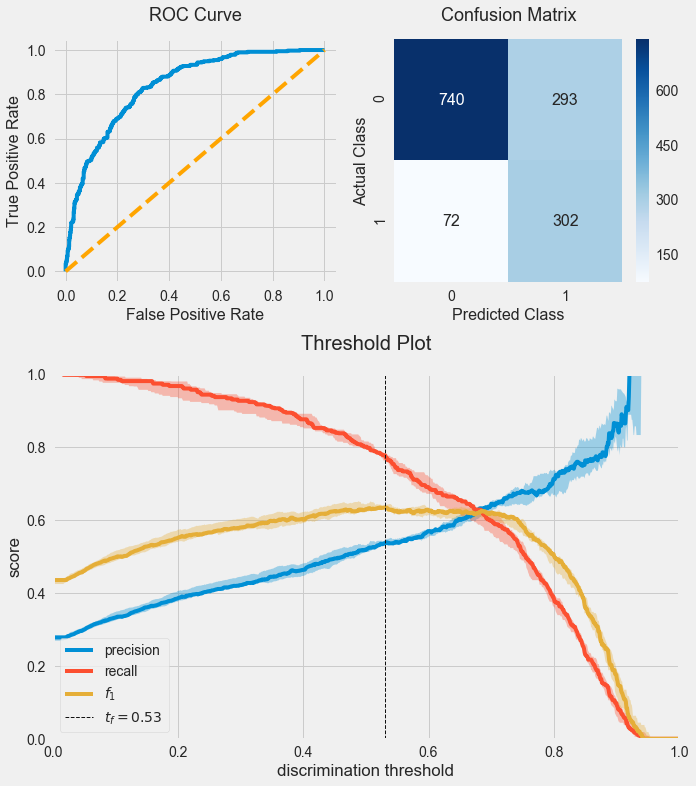

In [24]:
results_visualisations(logreg_model, X_train, y_train, X_test, y_test, SEED)

## Random Forest Classifier

#### Pre-tuned Random Forest

In [16]:
rforest = RandomForestClassifier(random_state=SEED, n_jobs=-1) 

Random Forest CV Results Summary
Mean Training Recall 	 99.57%
Mean Validation Recall 	 47.96%

Mean Fitting Time 	 1.9320s
Mean Scoring Time 	 0.1343s

Detailed Classification Report for Random Forest Model
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1033
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1407
   macro avg       0.75      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



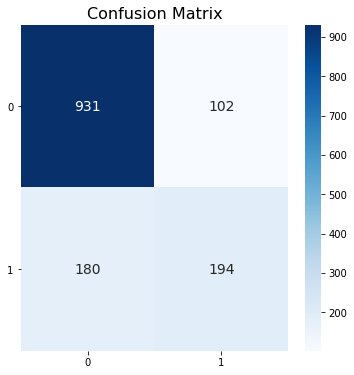

In [17]:
rforest_untuned = model_results_summary(rforest, X_train, y_train, X_test, y_test, cv_kwargs, model_name='Random Forest')

We observe that the baseline random forest classifier is overfitting the data. Lets do some hyper paramter tuning to improve its performance.

In [18]:
tune_rforest_params = {
    'n_estimators' : [100],
    'max_depth' : [5, 10, 15, 20, None],
    'min_samples_split' : [2],
    'min_samples_leaf' : np.arange(1,10,step=2),
    'max_features' : ['auto'],
    'criterion' : ['gini'],
    'class_weight' : ['balanced'],
    'bootstrap' : [True],
    'max_samples' : [0.7, 0.8, 0.9 , 1.0]
}

In [19]:
rforest_gscv = GridSearchCV(rforest, tune_rforest_params, scoring='recall', n_jobs=-1, cv=skf,
                            return_train_score=True)

In [20]:
rforest_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              m...
             iid='deprecated', n_jobs=-1,
             param_grid={'bootstrap': [True], 'class_weight': ['balanced'],
                         '

In [21]:
rforest_kwargs = rforest_gscv.best_params_
rforest_kwargs

{'bootstrap': True,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [22]:
best_rforest = rforest_gscv.best_estimator_

Tuned Random Forest CV Results Summary
Mean Training Recall 	 82.89%
Mean Validation Recall 	 81.20%

Mean Fitting Time 	 1.4895s
Mean Scoring Time 	 0.1727s

Detailed Classification Report for Tuned Random Forest Model
              precision    recall  f1-score   support

           0       0.92      0.71      0.81      1033
           1       0.51      0.83      0.64       374

    accuracy                           0.75      1407
   macro avg       0.72      0.77      0.72      1407
weighted avg       0.81      0.75      0.76      1407



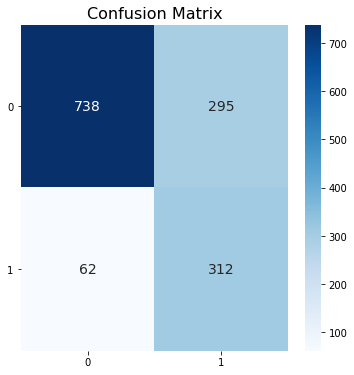

In [23]:
rforest_tuned = model_results_summary(best_rforest, X_train, y_train, X_test, y_test, cv_kwargs, model_name='Tuned Random Forest')

### Nearest Component Analysis and Nearest Neighbours

In [24]:
knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('KNN', KNeighborsClassifier())
])

In [25]:
tune_knn_params = {
    'KNN__n_neighbors' : np.arange(3,16, step=2),
    'KNN__weights' : ['uniform', 'distance'],
    'KNN__algorithm' : ['ball_tree', 'kd_tree'],
    'KNN__metric' : ['euclidean', 'manhattan'],
    'KNN__n_jobs' : [-1]
}

In [26]:
knn_gscv = GridSearchCV(knn_pipe, tune_knn_params, scoring='recall', n_jobs=-1, cv=skf,
                        return_train_score=True)

In [27]:
knn_gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=8888, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('Standardise',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('KNN',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [28]:
knn_gscv.best_score_

0.5351170568561873

In [29]:
knn_kwargs = knn_gscv.best_params_
knn_kwargs

{'KNN__algorithm': 'ball_tree',
 'KNN__metric': 'manhattan',
 'KNN__n_jobs': -1,
 'KNN__n_neighbors': 13,
 'KNN__weights': 'uniform'}

In [30]:
best_knn = knn_gscv.best_estimator_

K-Nearest Neighbours CV Results Summary
Mean Training Recall 	 59.00%
Mean Validation Recall 	 53.51%

Mean Fitting Time 	 0.1160s
Mean Scoring Time 	 0.6794s

Detailed Classification Report for K-Nearest Neighbours Model
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      1033
           1       0.61      0.56      0.58       374

    accuracy                           0.79      1407
   macro avg       0.73      0.71      0.72      1407
weighted avg       0.78      0.79      0.78      1407



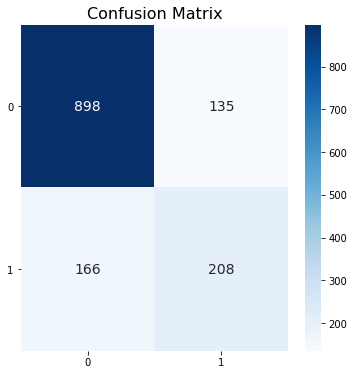

In [31]:
knn_tuned = model_results_summary(best_knn, X_train, y_train, X_test, y_test, cv_kwargs, model_name='K-Nearest Neighbours')

In [35]:
knn_params = {
    'n_neighbors' : 5,
    'weights' : 'uniform',
    'algorithm' : 'ball_tree',
    'metric' : 'manhattan',
    'n_jobs' : -1
}

In [36]:
from sklearn.neighbors import NeighborhoodComponentsAnalysis
nca_knn_pipe = Pipeline(steps=[
    ('Standardise', StandardScaler()),
    ('NCA', NeighborhoodComponentsAnalysis()),
    ('KNN', KNeighborsClassifier(**knn_params))
])

NCA-KNN CV Results Summary
Mean Training Recall 	 65.72%
Mean Validation Recall 	 49.63%

Mean Fitting Time 	 229.3420s
Mean Scoring Time 	 0.3285s

Detailed Classification Report for NCA-KNN Model
              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1033
           1       0.56      0.51      0.53       374

    accuracy                           0.76      1407
   macro avg       0.69      0.68      0.69      1407
weighted avg       0.76      0.76      0.76      1407



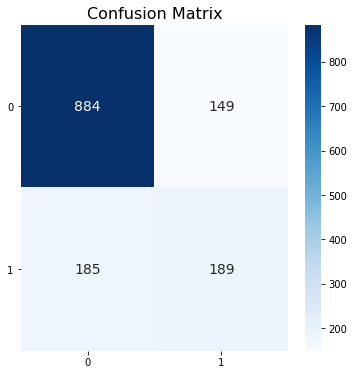

In [37]:
nca_knn_model = model_results_summary(nca_knn_pipe, X_train, y_train, X_test, y_test, cv_kwargs, model_name='NCA-KNN')